<a href="https://colab.research.google.com/github/rezu98/colab/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install nltk
!pip install vaderSentiment
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from openpyxl import Workbook, load_workbook
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
!pip install textstat
import textstat
from textstat import flesch_kincaid_grade, gunning_fog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00


In [6]:
!pip install openpyxl

In [7]:
file_path = 'results2.xlsx'

In [8]:
### Sentiment Intensity Analyzer
# Example text
sample_text = "The Monetary Policy Board of the Bank of Korea decided today to leave the Base Rate unchanged at 3.50% for the intermeeting period. Although inflation is projected to continue its underlying trend of a slowdown, uncertainties regarding the future path of inflation and growth have risen significantly due to a prolongation of restrictive monetary policy stances in major countries and heightened geopolitical risks. In addition, it is forecast that the pace of inflation slowdown will moderate more than previously expected, and it is necessary to monitor household debt growth. The Board, therefore, sees that it is appropriate to maintain its current restrictive policy stance. Regarding the need to raise the Base Rate further, the Board will make a judgement while assessing the changes in domestic and external policy conditions. The currently available information suggests that uncertainties regarding economic and inflationary trends have increased across the global economy, driven by a prolongation of restrictive monetary policy stances in major countries and by the Israel-Hamas conflict. Global economic growth is projected to continue slowing. Inflation in major countries still remains high, though falling gradually, and upside risks have increased due to the rise in global oil prices. In global financial markets, volatility of major price variables has increased with government bond yields rising significantly and with the U.S. dollar strengthening considerably. Looking ahead, the Board sees global economic growth and global financial markets as likely to be affected by the movements of global oil prices and the global inflation slowdown, by monetary policy changes in major countries and their effects, and by developments in the Israel-Hamas conflict. Domestic economic growth has continued to improve at a modest pace owing to the easing of sluggishness in exports, although the recovery in private consumption has been somewhat slow. Labor market conditions have been generally favorable, as both a low unemployment rate and a robust increase in the number of persons employed have continued. Going forward, domestic economic growth is expected to improve gradually with the easing of the sluggishness in exports. GDP growth for the year is expected to be generally consistent with the August forecast of 1.4%. However, uncertainties surrounding the economic outlook are judged to be elevated, affected by heightened geopolitical risks and by the prolongation of restrictive monetary policy stances in major countries. Consumer price inflation has risen from August to 3.7% in September, due to the increase in the price of energy and of agricultural products. However, both core inflation (excluding changes in food and energy prices from the CPI) and short-term inflation expectations among the general public have stayed at 3.3% in September, the same as in August. Looking ahead, it is forecast that consumer price inflation will fall to the lower-3% range at the end of this year and will continue to gradually moderate in 2024. However, upside risks to inflation have increased due to the effects of higher global oil prices and exchange rates, and due to the Israel-Hamas conflict. Accordingly, it is judged that the timing of consumer price inflation converging on the target level is more likely to be delayed than previously expected. Meanwhile, core inflation is also projected to maintain its underlying slowing trend, owing to the weakening of demand-side pressures. However, the pace of the slowdown is likely to be more modest than previously forecast due to the continuing spillover effects of accumulated cost pressure. In financial and foreign exchange markets, volatility has increased as the U.S. Federal Reserve has signaled a prolongation of a high policy rate and as geopolitical risks have expanded. Long-term Korean Treasury bond yields and the Korean won to U.S. dollar exchange rate have risen significantly and stock prices have fallen. Meanwhile, the risks to some non-bank financial sectors have eased. Housing prices have continued their upward trend, especially in Seoul and its surrounding areas. Household loans have continued to increase, mainly driven by housing-related loans. The Board will continue to conduct monetary policy in order to stabilize consumer price inflation at the target level over the medium-term horizon as it monitors economic growth, while paying attention to financial stability. While domestic economic growth is forecast to gradually improve, uncertainties surrounding the policy decision have also risen. The Board, therefore, will maintain a restrictive policy stance for a considerable time with an emphasis on ensuring price stability, while making a judgement regarding the need to raise the Base Rate further. In this process, the Board will thoroughly assess the inflation slowdown, financial stability risks, economic downside risks, monetary policy changes in major countries, household debt growth, and developments in geopolitical risks."
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Perform sentiment analysis
scores = analyzer.polarity_scores(sample_text)
print(scores)

{'neg': 0.077, 'neu': 0.828, 'pos': 0.095, 'compound': 0.9534}


In [9]:
### Sentiment Analyze

### by loughran and mcdonald(2019)

import datetime as dt
import sys
import nltk
nltk.download('punkt')

## loading master dictionary

def load_masterdictionary(file_path, print_flag=False, f_log=None, get_other=False):
    start_local = dt.datetime.now()
    # Setup dictionaries
    _master_dictionary = {}

    # Loop through words and load dictionaries
    with open(file_path, encoding="utf-8") as f:
        _total_documents = 0
        _md_header = f.readline()  # Consume header line
        print()
        for line in f:
            cols = line.rstrip('\n').split(',')
            word = cols[0].upper()  # Convert word to uppercase
            negative_value = int(cols[7])
            positive_value = int(cols[8])
            uncertainty_value = int(cols[9])
            _master_dictionary[word] = {'negative': negative_value, 'positive': positive_value, 'uncertainty': uncertainty_value}

    if print_flag:
        print('\r', end='')  # clear line
        print(f'\nMaster Dictionary loaded from file:\n  {file_path}\n')
        print(f'  master_dictionary has {len(_master_dictionary):,} words.\n')

    if get_other:
        return _master_dictionary, _md_header, _total_documents
    else:
        return _master_dictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
## evaluate sentiment indices

def evaluate_sentiment_indices(text, master_dictionary):
    words = nltk.word_tokenize(text)  # Tokenize the text into words
    words_uppercase = [word.upper() for word in words]  # Convert all words to uppercase
    total_words_count, negative_score, positive_score, uncertain_words_count = 0, 0, 0, 0
    negative_words_count, positive_words_count = 0, 0

    for word in words_uppercase:
        if word in master_dictionary:
            total_words_count += 1  # Increment the total word count
            if master_dictionary[word]['uncertainty'] != 0:
                uncertain_words_count += 1
            if master_dictionary[word]['negative'] > 0:
                negative_words_count += 1
            if master_dictionary[word]['positive'] > 0:
                positive_words_count += 1

    negative_index = negative_words_count / total_words_count  # Calculate the negative index
    positive_index = positive_words_count / total_words_count  # Calculate the positive index
    uncertainty_index = uncertain_words_count / total_words_count  # Calculate the uncertainty index

    return negative_index, positive_index, uncertainty_index, total_words_count, uncertain_words_count, negative_words_count, positive_words_count

if __name__ == '__main__':
    start = dt.datetime.now()
#    print(f'\n\n{start.strftime("%c")}\nPROGRAM NAME: {sys.argv[0]}\n')
    md = r'c.csv'  # Update with your file path
    master_dictionary = load_masterdictionary(md, True)



Master Dictionary loaded from file:
  c.csv

  master_dictionary has 86,531 words.



In [11]:
### Financial Stability Dictionary
### by Correa, Ricardo & Keshav Garud & Juan M. Londono & Nathan Mislang, 2021. "Sentiment in Central Banks' Financial Stability Reports," Review of Finance, vol. 25(1), pages 85-120.

# Load the workbook
file_path_fs = 'f.xlsx'
workbook_fs = load_workbook(file_path_fs)
worksheet_fs = workbook_fs['1 FS Dictionary']

# Extract the words and their respective positive, negative, and assign values
fs_words = []
fs_positives = []
fs_negatives = []
fs_assigns = []

for row in worksheet_fs.iter_rows(min_row=2, min_col=1, max_col=4):
    if row[0].value:
        fs_words.append(row[0].value)
        fs_positives.append(row[1].value)
        fs_negatives.append(row[2].value)
        fs_assigns.append(row[3].value)

# Define the function to count the words in the fs dictionary in the original text and calculate the sum of positive and negative values
def count_fs_words(text, fs_words, fs_positives, fs_negatives):
    text_words = nltk.word_tokenize(text)  # Tokenize the text into words
    fs_positive_words = [word for word in text_words if word in fs_words and fs_positives[fs_words.index(word)] == 1]
    fs_negative_words = [word for word in text_words if word in fs_words and fs_negatives[fs_words.index(word)] == 1]
    fs_positive_sum = sum([fs_positives[fs_words.index(word)] for word in text_words if word in fs_words and fs_positives[fs_words.index(word)] == 1])
    fs_negative_sum = sum([fs_negatives[fs_words.index(word)] for word in text_words if word in fs_words and fs_negatives[fs_words.index(word)] == 1])
    return fs_positive_sum, fs_negative_sum, fs_positive_words, fs_negative_words

In [12]:
## Readiability

def evaluate_readability(text):
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)
    num_sentences = len(sentences)
    num_words = len(words)
    num_syllables = 0
    for word in words:
        num_syllables += textstat.syllable_count(word)
    return textstat.flesch_kincaid_grade(text), textstat.gunning_fog(text)

In [ ]:
### Example FOMC statement to evaluate - manually calculating

date = "2010.10"

fomc_statement = """
   The Monetary Policy Committee of the Bank of Korea decided today to maintain the Base Rate at its current level (2.25%) for the intermeeting period.



In the global economy, emerging market economies have sustained their favorable performance, and the economies of major advanced countries have largely continued their moderate recovery trend, even though the pace of the recovery in the US economy has slowed somewhat. Looking ahead, there exists the possibility of the heightened volatility of economic activity and exchange rates in major countries acting as a risk factor for the global economy.



The underlying upward trend of domestic business activity has been maintained. Even though consumption has faltered, exports have sustained their buoyancy and facilities investment has increased. And, led by the private sector, labor market conditions have shown an improving trend.



The domestic economy is expected to continue on an underlying upward track, even in the presence of external risk.



Consumer price inflation has increased due to a sudden rise in farm product prices, and in the future, upward pressures on the demand side are expected to continue, being associated with the continued upswing in activity. In the real estate market, housing sales prices have continued to decline in Seoul and its surrounding areas, while those in other areas have maintained their increase.


In the financial markets, stock prices have risen, the Korean won has appreciated, and market interest rates have declined in response chiefly to the expanded inflow of foreign portfolio investment funds. The scale of the growth in mortgage lending has widened due to the increase in the numbers of newly occupied apartments, even though house transactions have been inactive.



Looking ahead, the Committee will conduct monetary policy in such a way as to help the economy maintain price stability, while sustaining sound growth under the accommodative policy stance. In carrying out policy, it will take overall account of financial and economic conditions at home and abroad



 """


 ## run!!!

if __name__ == '__main__':
    start = dt.datetime.now()
    md = r'c.csv'  # Update with your file path
    master_dictionary = load_masterdictionary(md, True)

    # Remove unnecessary line breaks and spaces
    processed_text = re.sub(r'\n+', ' ', fomc_statement)  # Replace multiple line breaks with a single space
    processed_text = re.sub(r' +', ' ', processed_text)  # Replace multiple spaces with a single space

    negative_index, positive_index, uncertainty_index, total_words_count, uncertain_words_count, negative_words_count, positive_words_count = evaluate_sentiment_indices(processed_text, master_dictionary)
    flesch_kincaid_grade, gunning_fog_index = evaluate_readability(processed_text)
    fs_positive_sum, fs_negative_sum, fs_positive_words, fs_negative_words = count_fs_words(processed_text, fs_words, fs_positives, fs_negatives)

    print(f"\nNumber of uncertain words: {uncertain_words_count}")
    print(f"Number of negative words: {negative_words_count}")
    print(f"Number of positive words: {positive_words_count}")
    print(f"Number of total words: {total_words_count}")
    print(f"Negative index for the FOMC statement: {negative_index:.2f}")
    print(f"Positive index for the FOMC statement: {positive_index:.2f}")
    print(f"Uncertainty index for the FOMC statement: {uncertainty_index:.2f}")
    print(f"Flesch-Kincaid Grade Level: {flesch_kincaid_grade}")
    print(f"Gunning Fog Index: {gunning_fog_index}")
    print(f"FS positive sum: {fs_positive_sum}")
    print(f"FS negative sum: {fs_negative_sum}")
    print(f"FS_positive_words: {fs_positive_words}")
    print(f"FS_negative_words: {fs_negative_words}")

    # Printing the actual words defined as positive, negative, and uncertainty
    words = nltk.word_tokenize(processed_text)
    words_uppercase = [word.upper() for word in words]  # Convert all words to uppercase
    words_with_sentiment = [(word, master_dictionary[word]) for word in words_uppercase if word in master_dictionary]
    positive_words = [word for word, sentiment in words_with_sentiment if sentiment['positive'] > 0]
    negative_words = [word for word, sentiment in words_with_sentiment if sentiment['negative'] > 0]
    uncertain_words = [word for word, sentiment in words_with_sentiment if sentiment['uncertainty'] > 0]
    print(f"Positive words: {positive_words}")
    print(f"Negative words: {negative_words}")
    print(f"Uncertainty words: {uncertain_words}")


# Check if the file already exists, and load it if it does
try:
    workbook = load_workbook(file_path)
    sheet = workbook.active
except FileNotFoundError:
    workbook = Workbook()
    sheet = workbook.active
    sheet.append(['Date', 'FOMC Statement', 'Positive Words', 'Negative Words', 'Uncertainty Words', 'Total Words', 'Positive Words List', 'Negative Words List', 'Uncertainty Words List', 'Flesch-Kincaid Grade Level', 'Gunning Fog Index', 'FS Positive_Counts', 'FS Negative_Counts', 'FS Positive Words', 'FS Negative Words'])


# Append results to the Excel file
sheet.append([date, processed_text, positive_words_count, negative_words_count, uncertain_words_count, total_words_count, ', '.join(positive_words), ', '.join(negative_words), ', '.join(uncertain_words), flesch_kincaid_grade, gunning_fog_index, fs_positive_sum, fs_negative_sum, '.join(fs_positive_words), ', '.join(fs_negative_words)'])

# Save the workbook
workbook.save(file_path)


In [ ]:
### FOMC statement to evaluate - using existing library - cleaning needed. imprecise.

# dataset = dataset, dataset_minutes, dataset_speechs
# dataset = dataset_statement

# Check if the file already exists, and load it if it does
try:
    workbook = load_workbook(file_path)
    sheet = workbook.active
except FileNotFoundError:
    workbook = Workbook()
    sheet = workbook.active
    sheet.append(['Date', 'FOMC Statement', 'Positive Words', 'Negative Words', 'Uncertainty Words', 'Total Words', 'Positive Words List', 'Negative Words List', 'Uncertainty Words List', 'Flesch-Kincaid Grade Level', 'Gunning Fog Index', 'FS Positive_Counts', 'FS Negative_Counts', 'FS Positive Words', 'FS Negative Words'])

# Loop through the dataset and process each row
for index, row in dataset.iterrows():
    # Retrieve the date and FOMC statement from the current row
    date = row['date']  # Assuming the column name for the date is 'date'
    fomc_statement = row['statement']  # Assuming the column name for the statement is 'statement'

    # Your existing code
    start = dt.datetime.now()
    md = r'c.csv'  # Update with your file path
    master_dictionary = load_masterdictionary(md, True)

    # Remove unnecessary line breaks and spaces
    processed_text = re.sub(r'\n+', ' ', fomc_statement)
    processed_text = re.sub(r' +', ' ', processed_text)

    # Perform sentiment analysis, readability calculation, and other necessary calculations here

    negative_index, positive_index, uncertainty_index, total_words_count, uncertain_words_count, negative_words_count, positive_words_count = evaluate_sentiment_indices(processed_text, master_dictionary)
    flesch_kincaid_grade, gunning_fog_index = evaluate_readability(processed_text)
    fs_positive_sum, fs_negative_sum, fs_positive_words, fs_negative_words = count_fs_words(processed_text, fs_words, fs_positives, fs_negatives)

    # Printing the actual words defined as positive, negative, and uncertainty
    words = nltk.word_tokenize(processed_text)
    words_uppercase = [word.upper() for word in words]  # Convert all words to uppercase
    words_with_sentiment = [(word, master_dictionary[word]) for word in words_uppercase if word in master_dictionary]
    positive_words = [word for word, sentiment in words_with_sentiment if sentiment['positive'] > 0]
    negative_words = [word for word, sentiment in words_with_sentiment if sentiment['negative'] > 0]
    uncertain_words = [word for word, sentiment in words_with_sentiment if sentiment['uncertainty'] > 0]

    # Append results to the Excel file
    sheet.append([date, processed_text, positive_words_count, negative_words_count, uncertain_words_count, total_words_count, ', '.join(positive_words), ', '.join(negative_words), ', '.join(uncertain_words), flesch_kincaid_grade, gunning_fog_index, fs_positive_sum, fs_negative_sum, ', '.join(fs_positive_words), ', '.join(fs_negative_words)])

# Save the workbook
workbook.save(file_path)

In [32]:
### Elminate stop words(conjunction, article, and preposition)

# Function to remove stopwords from a piece of text
def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

In [50]:
# Load the data from the Excel file
dataset_cleaning = pd.read_excel(file_path, engine='openpyxl')

# Get the stopwords list
stop_words = set(stopwords.words('english'))

# Apply the remove_stopwords function to the 'FOMC Statement' column and save the result to 'FOMC Statement_no_stopwords'
dataset_cleaning['FOMC Statement_no_stopwords'] = dataset_cleaning['FOMC Statement'].apply(remove_stopwords)

# Calculate the number of words
dataset_cleaning['words_cleaning'] = dataset_cleaning['FOMC Statement_no_stopwords'].str.split().apply(len)

# Calculate the number of occurrences of the word 'will'
dataset_cleaning['forward_words_will'] = dataset_cleaning['FOMC Statement'].str.count(r'\bwill\b')

# Calculate the number of occurrences of the word 'expect'
dataset_cleaning['forward_words_expect'] = dataset_cleaning['FOMC Statement'].str.count(r'\bexpect\b')

# Calculate the number of occurrences of the word 'may'
dataset_cleaning['forward_words_may'] = dataset_cleaning['FOMC Statement'].str.count(r'\bmay\b')

# Calculate the number of occurrences of the word 'might'
dataset_cleaning['forward_words_might'] = dataset_cleaning['FOMC Statement'].str.count(r'\bmight\b')

# Save the modified DataFrame to a new Excel file
with pd.ExcelWriter('new_results.xlsx', engine='openpyxl') as writer:
    dataset_cleaning.to_excel(writer, index=False, sheet_name='Sheet1')

In [ ]:
### Ziff's law and tf-idf score

# Load the excel
# file_path = 'results2.xlsx'
dataset_ziff = pd.read_excel(file_path)
# If Uncertainty Words List, it has vacant values. So use the following code.

# You may need to adjust the column names based on your dataset
dates = dataset_ziff['Date']
statements = dataset_ziff['Negative Words List']

# Create a dictionary to store words by their respective dates
words_by_date = {}

for index, statement in enumerate(statements):
    # Filter the statements to consider only those after 2019
    if dates[index].year < 2020:
        continue

    # Tokenize the text into words
    words = nltk.word_tokenize(statement)

    # Store the words with their respective date
    date = dates[index]
    if date not in words_by_date:
        words_by_date[date] = []
    words_by_date[date].extend(words)

# Now words_by_date dictionary contains the words stored by their respective dates after 2019

# Convert the words_by_date dictionary into a DataFrame
data = {'Date': list(words_by_date.keys()), 'Words': list(words_by_date.values())}
dataset_result_ziff = pd.DataFrame(data)

# Save the DataFrame to an Excel file
dataset_result_ziff.to_excel('result_word.xlsx', index=False)

In [ ]:
## Ziff's law

# Assuming you have already created the 'df' DataFrame
words_list = dataset_result_ziff['Words'].tolist()
words_flat = [word for sublist in words_list for word in sublist]

# Ziff's Law
word_counts = Counter(words_flat)
sorted_word_counts = sorted(word_counts.values(), reverse=True)
ranks = list(range(1, len(sorted_word_counts) + 1))
log_ranks = np.log(ranks)
log_counts = np.log(sorted_word_counts)

# Plot the scatter plot
plt.scatter(log_ranks, log_counts, color='b', alpha=0.5)
plt.title("Scatter plot for Ziff's Law")
plt.xlabel("Log of Ranks")
plt.ylabel("Log of Word Frequencies")
plt.show()

In [ ]:
## TF-idf score

# TF-IDF Scores
text = [' '.join(words) for words in words_list]

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=dataset_result_ziff['Date'])

# Save the results to Excel files
# ziffs_law_df = pd.DataFrame({'Ranks': ranks, 'Log Counts': log_counts, 'Log Ranks': log_ranks})
# ziffs_law_df.to_excel('ziffs_law_results.xlsx', index=False)
tfidf_df.to_excel('tfidf_scores.xlsx')

In [29]:
### Relationship between words

# Load the excel
dataset_relationship = pd.read_excel(file_path)

# Define the word of interest
target_word = 'crisis'

# Initialize a counter for the occurrences of the target word
occurrences_counter = 0

# Iterate through the dataset to process the FOMC statements
for index, row in dataset_relationship.iterrows():
    date = row['Date']
    statement = row['FOMC Statement']

    # Check if the date falls within your specified time span
    if date.year < 2020:
        continue

    # Tokenize the FOMC statement into sentences
    sentences = nltk.sent_tokenize(statement)

    # Iterate through each sentence and check for occurrences of the target word
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        if target_word in words:
            index_of_word = words.index(target_word)

            # Extract the surrounding words
            words_around = words[max(0, index_of_word - 20): min(len(words), index_of_word + 25)]
            print(f"Date: {date}, {' '.join(words_around)}")


            # Increment the counter
            occurrences_counter += 1

# Print the total number of occurrences of the target word
print(f"Total occurrences of '{target_word}': {occurrences_counter}")

Date: 2020-04-29 00:00:00, The ongoing public health crisis will weigh heavily on economic activity , employment , and inflation in the near term , and poses considerable risks to the economic outlook
Date: 2020-06-10 00:00:00, The ongoing public health crisis will weigh heavily on economic activity , employment , and inflation in the near term , and poses considerable risks to the economic outlook
Date: 2020-07-29 00:00:00, The ongoing public health crisis will weigh heavily on economic activity , employment , and inflation in the near term , and poses considerable risks to the economic outlook
Date: 2020-09-16 00:00:00, The ongoing public health crisis will continue to weigh on economic activity , employment , and inflation in the near term , and poses considerable risks to the economic
Date: 2020-11-05 00:00:00, The ongoing public health crisis will continue to weigh on economic activity , employment , and inflation in the near term , and poses considerable risks to the economic
Dat

In [63]:
### Co-occurence Matrix

# Load the dataset
dataset = pd.read_excel(file_path)

# Concatenate all text values in 'FOMC Statement' into a single value
concat_statements = ' '.join(dataset['FOMC Statement'])

# Concatenate all text values in 'FOMC Statement' into a list of strings
concat_statements = dataset['FOMC Statement'].tolist()

# Define the base words
base_words = ['will', 'coronavirus', 'covid', 'virus', 'crisis', 'war', 'impede', 'hardship', 'tremendous', 'challenging']

# Tokenize words and adjust the window size
vectorizer = CountVectorizer(vocabulary=base_words, ngram_range=(1, 20), stop_words='english')
X = vectorizer.fit_transform(concat_statements)
co_occurrence_matrix = X.T * X

# Convert the co-occurrence matrix to a DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())

# Print the co-occurrence matrix
print(co_occurrence_df)

             will  coronavirus  covid  virus  crisis  war  impede  hardship  \
will            0            0      0      0       0    0       0         0   
coronavirus     0            8      0      3       3    0       0         3   
covid           0            0     13     13       8    0      13         8   
virus           0            3     13     21      12    0      14         9   
crisis          0            3      8     12      12    0       9         9   
war             0            0      0      0       0   17       9         9   
impede          0            0     13     14       9    9      25        14   
hardship        0            3      8      9       9    9      14        17   
tremendous      0            3      8      9       9    9      14        17   
challenging     0            5     10     15      12    0      11         9   

             tremendous  challenging  
will                  0            0  
coronavirus           3            5  
covid        

In [111]:
### Wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_excel(file_path)
# after 2019
# Concatenate all text values in 'FOMC Statement' into a single value
concat_statements = ' '.join(dataset['FOMC Statement'])

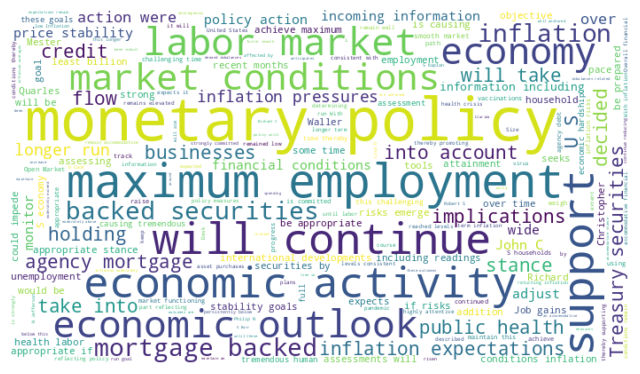

In [118]:
# Generate a word cloud image(for 2020~)
wordcloud = WordCloud(width=700, height=400, background_color='white', colormap='viridis', stopwords=['and', 'the', 'to', 'of', 'in', 'for', 'a', 'Federal', 'Reserve', 'Committee', 'that', 'at', 'percent', 'williams', 'Vice', 'Voting', 'W Bowman', 'C Wiliams', 'Michelle', 'Jerome', 'H Powell', 'Bowman', 'W', 'H', 'Loretta', 'J', 'Last Update', 'Powell', 'Chair', 'Patrick', 'Harker', 'Randal', 'K', 'Lael', 'Brainard', 'has', 'on', 'as', 'have', 'month', 'per','its', 'Last', 'Update', 'Neel', 'Kashkari', 'target', 'range', 'funds', 'rate']).generate(concat_statements)

# Generate a word cloud image(before 2020~)
# wordcloud = WordCloud(width=700, height=400, background_color='white', colormap='viridis', stopwords=['and', 'the', 'to', 'of', 'in', 'for', 'a', 'Federal', 'Reserve', 'Committee', 'that', 'at', 'percent', 'williams', 'Vice', 'Voting', 'W Bowman', 'C Wiliams', 'Michelle', 'Jerome', 'H Powell', 'Bowman', 'W', 'H', 'Loretta', 'J', 'Last Update', 'Powell', 'Chair', 'Patrick', 'Harker', 'Randal', 'K', 'Lael', 'Brainard', 'has', 'on', 'as', 'have', 'month', 'per','its', 'Last', 'Update', 'Neel', 'Kashkari', 'funds', 'rate', 'Bernanke', 'S', 'Janet', 'L', 'Chairman', 'target', 'range', 'willaim']).generate(concat_statements)

# Display the generated word cloud image
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

!!! Web crawling of FOMC Statements

In [ ]:
!pip install Fedtools

from FedTools import MonetaryPolicyCommittee
from FedTools import BeigeBooks
from FedTools import FederalReserveMins

In [ ]:
monetary_policy = MonetaryPolicyCommittee(
            main_url = 'https://www.federalreserve.gov',
            calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year = 2000,
            historical_split = 2014,
            verbose = True,
            thread_num = 10)

In [ ]:
dataset = monetary_policy.find_statements()
dataset.reset_index(inplace=True)
dataset.columns = ['date', 'statement']

In [ ]:
# from FedTools import BeigeBooks

# dataset = BeigeBooks().find_beige_books()
# BeigeBooks().pickle_data("directory.pkl")

In [ ]:
from FedTools import FederalReserveMins

dataset_minutes = FederalReserveMins().find_minutes()
dataset_minutes.reset_index(inplace=True)
dataset_minutes.columns = ['date', 'statement']

In [ ]:
import os
import sys
import urllib.request
client_id = "0MhoFcb7LR_ehhiyYObe" # 개발자센터에서 발급받은 Client ID 값
client_secret = "e0nXtPkgPV" # 개발자센터에서 발급받은 Client Secret 값
encText = urllib.parse.quote("반갑습니다")
data = "source=ko&target=en&text=" + encText
url = "https://openapi.naver.com/v1/papago/n2mt"
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request, data=data.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)